# Data Cleaning
This script is for processing and cleaning nsf award data. Award data appears to be organized by award and we've got about 4GB of data. 

Award files consists of a single XML file for each award and contains awards for many years (1959-2022). They seem to be inconsistently formatted but have an underlying static schema that is guaranteed to be present in each file. Let's take a look at that first to see what we are working with.

In [1]:
!python -m pip install nltk


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# libraries for data cleaning
# for parsing xml data 
import xml.etree.ElementTree as ET
import os 

# for data manipulation
import pandas as pd 
import numpy as np

#for text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

# for data visualization
import matplotlib.pyplot as plt
from math import log10 

In [3]:
# for reproducibility
!python -m pip list > requirements.txt
!python --version
#TODO add requirements.txt to github and strip down to only what is needed


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Python 3.9.1


In [4]:
#take a look at the schema of the data
ET.dump(ET.parse('Award.xsd').getroot())

<xs:schema xmlns:xs="http://www.w3.org/2001/XMLSchema" attributeFormDefault="unqualified" elementFormDefault="qualified" version="1.0">
  <xs:element name="rootTag">
    <xs:complexType>
      <xs:sequence>
        
        <xs:element name="Award">
          <xs:complexType>
            <xs:sequence>
              <xs:element name="AwardTitle" type="xsd:string" />
              <xs:element name="AwardEffectiveDate" type="xsd:dateTime" />
              <xs:element name="AwardExpirationDate" type="xsd:dateTime" />
              <xs:element name="AwardAmount" type="xsd:int" />
              
              <xs:element name="AwardInstrument">
                <xs:complexType>
                  <xs:sequence>
                    <xs:element name="Value" type="xsd:string" />
                  </xs:sequence>
                </xs:complexType>
              </xs:element>
              
              <xs:element name="Organization">
                <xs:complexType>
                  <xs:sequence>


The important part is that there are dates, dollars (AwardAmount), and lots of textual data (AwardTitle, AbstractNarration). We can work with this. Let get this into a csv file and see how messy it is. 

In [34]:
#iterate over a single file and extract the following information:
# AbstractNarration
# AwardAmount
# AwardTitle
# Directorates

def extract_data(fpath):
    """Extracts the award_id, title, amount, and abstract from a single xml file"""
    tree = ET.parse(fpath)
    root = tree.getroot()
    award = root.find('Award')
    division = award.find('Organization').find("Division").find("LongName").text
    
    amount = award.find('AwardAmount').text
    title = award.find('AwardTitle').text
    abstract = award.find('AbstractNarration').text
    award_id = award.find('AwardID').text

    return award_id, title, amount, abstract, division



('1700009', 'Spectral Properties of Random Band Matrices and Related Questions', '119998', 'This research project intertwines mathematical and physics-related areas including matrix theory, probability, classical analysis and operator theory, as well as topics in physics such as quantum field theory and supersymmetry.  The method of supersymmetry is widely used in theoretical physics, especially in particle physics, but its rigorous mathematical foundation is still a challenge for mathematicians. The aim of the project is to develop a broad mathematical understanding of supersymmetry.&lt;br/&gt;&lt;br/&gt;More precisely, random band matrices (RBM) represent quantum systems on a d-dimensional lattice with random quantum transition amplitudes effective up to distances of some order W, which is called a bandwidth. They are natural intermediate models in the study eigenvalue statistics and quantum propagation of disordered systems;  they interpolate between Wigner random matrices and rando

In [35]:
#testing the function
print(extract_data('data/raw-data/2017/1700009.xml'))
print(extract_data('data/raw-data/2021/2100003.xml'))
print(extract_data('data/raw-data/2021/2120701.xml'))

('1700009', 'Spectral Properties of Random Band Matrices and Related Questions', '119998', 'This research project intertwines mathematical and physics-related areas including matrix theory, probability, classical analysis and operator theory, as well as topics in physics such as quantum field theory and supersymmetry.  The method of supersymmetry is widely used in theoretical physics, especially in particle physics, but its rigorous mathematical foundation is still a challenge for mathematicians. The aim of the project is to develop a broad mathematical understanding of supersymmetry.&lt;br/&gt;&lt;br/&gt;More precisely, random band matrices (RBM) represent quantum systems on a d-dimensional lattice with random quantum transition amplitudes effective up to distances of some order W, which is called a bandwidth. They are natural intermediate models in the study eigenvalue statistics and quantum propagation of disordered systems;  they interpolate between Wigner random matrices and rando

In [36]:
#iterate over all files in the data directory and extract the data #this can take a few mins
data = []
bad_files = []
count = 0

for year in os.listdir('data/raw-data/'):
    print(f"working on year: {year}")
    for f in os.listdir(f'data/raw-data/{year}'):
        fpath = f'data/raw-data/{year}/{f}'
        try:
            data.append(extract_data(fpath))
            count += 1

            if count % 10000 == 0:
                print(f"total files processed: {count}")
        except: 
            bad_files.append(fpath)


working on year: 2000
total files processed: 10000
working on year: 2001
total files processed: 20000
working on year: 2002
total files processed: 30000
working on year: 2003
total files processed: 40000
working on year: 2004
total files processed: 50000
working on year: 2005
total files processed: 60000
working on year: 2006
total files processed: 70000
working on year: 2007
total files processed: 80000
working on year: 2008
total files processed: 90000
total files processed: 100000
working on year: 2009
total files processed: 110000
working on year: 2010
total files processed: 120000
working on year: 2011
total files processed: 130000
total files processed: 140000
working on year: 2012
total files processed: 150000
working on year: 2013
total files processed: 160000
working on year: 2014
total files processed: 170000
working on year: 2015
total files processed: 180000
working on year: 2016
total files processed: 190000
total files processed: 200000
working on year: 2017
total files p

In [37]:
#see how many files were processed
print(f"total files processed: {count}")

#see how many files were not processed
print(f"total files not processed: {len(bad_files)}")

#see what the bad files look like
print(bad_files[-9:])



total files processed: 265152
total files not processed: 27
['data/raw-data/2008/0834750.xml', 'data/raw-data/2008/0840444.xml', 'data/raw-data/2009/0917266.xml', 'data/raw-data/2010/1022648.xml', 'data/raw-data/2010/1028076.xml', 'data/raw-data/2010/1066456.xml', 'data/raw-data/2011/1111766.xml', 'data/raw-data/2011/1116739.xml', 'data/raw-data/2011/1117597.xml']


Only 27 files not processed so just skip them.

In [58]:
#produce a pandas dataframe from the data
df = pd.DataFrame(data, columns=['award_id', 'title', 'amount', 'abstract', 'division'])

#get size of data in GB
print(f"size of data is {df.memory_usage(deep=True).sum() / 1e9} GB")

size of data is 0.783151583 GB


In [59]:
#what's missing from the data
print(df.isna().sum())

award_id       0
title          3
amount         1
abstract    4058
division       0
dtype: int64


In [60]:
#unique divisions
sorted(df['division'].unique())

['Arctic Sciences Division',
 'Budget Division',
 'CISE Information Technology Research',
 'DIVISION OF EDUCATIONAL SYSTEM REFORM',
 'DIVISION OF EXPERIMENTAL & INTEG ACTIVIT',
 'Direct For Biological Sciences',
 'Direct For Computer & Info Scie & Enginr',
 'Direct For Mathematical & Physical Scien',
 'Direct For Social, Behav & Economic Scie',
 'Directorate For Engineering',
 'Directorate For Geosciences',
 'Directorate for STEM Education',
 'Div Atmospheric & Geospace Sciences',
 'Div Of Biological Infrastructure',
 'Div Of Chem, Bioeng, Env, & Transp Sys',
 'Div Of Civil, Mechanical, & Manufact Inn',
 'Div Of Electrical, Commun & Cyber Sys',
 'Div Of Elem Secondary & Informal Sci Ed',
 'Div Of Engineering Education and Centers',
 'Div Of Industrial Innovation & Partnersh',
 'Div Of Information & Intelligent Systems',
 'Div Of Molecular and Cellular Bioscience',
 'Div Of Rsch, Evaluation and Communicatio',
 'Div of Res, Innovation, Synergies, & Edu',
 'Div. of Equity for Excellence i

<AxesSubplot:>

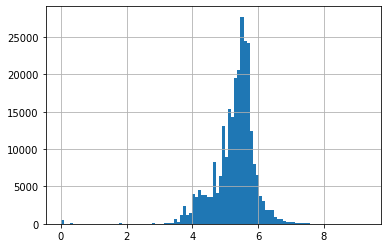

In [61]:
#look at award amounts on a log scale
df['amount'] = df['amount'].astype(float)
df['amount'].apply(lambda x:log10(abs(x)+1) if x is not None else 0).hist(bins=100)

<AxesSubplot:>

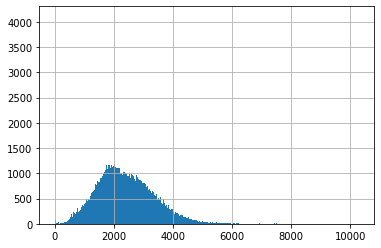

In [62]:
#look at abstract lengths.
df['abstract'].apply(lambda x:len(x) if x is not None else 0).hist(bins=1000)

<AxesSubplot:>

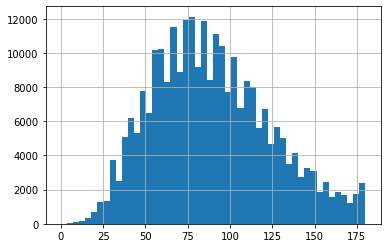

In [63]:
#look at title lengths
df['title'].apply(lambda x:len(x) if x is not None else 0).hist(bins=50)

In [64]:
old_size = df.shape[0]

#will remove missing rows, awards below $30000, and abstracts below 20 characters
df = df.dropna()

#remove awards below $30000
df = df[df['amount'] > 30000]

#remove abstracts below 20 characters
df = df[df['abstract'].apply(lambda x:len(x) if x is not None else 0) > 20]

print(f"retained { round(df.shape[0]/old_size*100,ndigits=2) }% of rows")

retained 87.54% of rows


In [65]:
#clean up the abstracts
#general preprocessing

#lowercase
df['abstract'] = df['abstract'].apply(lambda x: x.lower())

#remove numbers
df['abstract'] = df['abstract'].apply(lambda x: re.sub(r'\d+', '', x))

#remove words that are less than 3 characters
df['abstract'] = df['abstract'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

#remove words that are greater than 40 characters
df['abstract'] = df['abstract'].apply(lambda x: ' '.join([word for word in x.split() if len(word) < 41]))

Other preprocessing are task specific (stemming, lemmatization, etc). So will save data as-is for later use.

In [66]:
#save to csv file
df.to_csv('data/cleaned_data.csv', index=False)